In [1]:
from dataset import AtomsDataset

In [2]:
import torch

In [3]:
train_folderpath = "./cif-files/train"
train_dataset = AtomsDataset(train_folderpath)

In [4]:
test_folderpath = "./cif-files/test"
test_dataset = AtomsDataset(test_folderpath)

In [5]:
from torch_geometric.loader import DataLoader

In [6]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=32,
                          shuffle=True)

In [7]:
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=32,
                         shuffle=True)

In [7]:
from gae import GAE, train_epoch, validate_epoch

In [9]:
model = GAE()

In [10]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,          
    weight_decay=1e-5  # regularization
)

In [11]:
from torch_geometric.data import Batch

In [12]:
validate_epoch(model, test_loader)

{'total': 30.052718026297434,
 'node_loss': 19.403130531311035,
 'edge_feat': 4.401252167565482,
 'edge_bce': 6.248335089002337}

In [13]:
from typing import Dict, List
from tqdm import tqdm

In [14]:
def train(model: GAE,
          train_loader: DataLoader,
          test_loader: DataLoader,
          train_stats: Dict[str, List[float]],
          test_stats: Dict[str, List[float]],
          n_epochs: int):
    labels = ['total', 'node_loss', 'edge_feat', 'edge_bce']
    for label in labels:
        train_stats[label] = []
        test_stats[label] = []

    for epoch in tqdm(range(1, n_epochs+1)):
        train_stat = train_epoch(model, train_loader, optimizer)
        test_stat = validate_epoch(model, test_loader)
        if epoch % 5 == 0:
            for label in labels:
                train_stats[label].append(train_stat[label])
                test_stats[label].append(test_stat[label])


In [15]:
train_stats = {}
test_stats = {}

In [16]:
n_epochs=100

In [17]:
train(model, train_loader, test_loader, train_stats, test_stats, n_epochs)

100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


In [18]:
torch.save(model.state_dict(), "gae.pt")

In [20]:
import matplotlib.pyplot as plt

In [21]:
import numpy as np

In [22]:
def plot(train_stats: List[float], test_stats: List[float], ylabel: str, title: str, n_epochs: int, save: str):
    x = np.arange(1, n_epochs+1, 5)
    plt.plot(x, train_stats, label="train stats", color="blue")
    plt.plot(x, test_stats, label="test_stats", color="red")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.savefig(f"{save}.png")
    # print("train_stats", train_stats)
    # print("test_stats", test_stats)


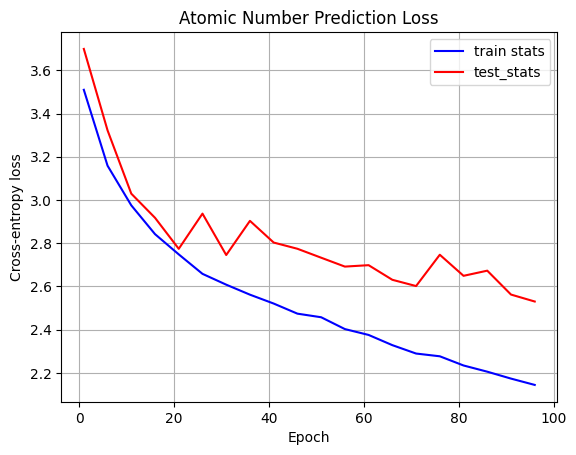

In [23]:
plot(train_stats['node_loss'], test_stats['node_loss'], "Cross-entropy loss", "Atomic Number Prediction Loss", n_epochs, 'node_loss')


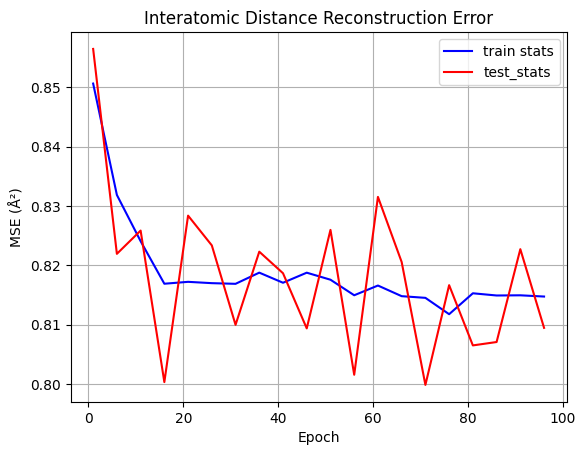

In [24]:
plot(train_stats['edge_feat'], test_stats['edge_feat'], "MSE (Å²)", "Interatomic Distance Reconstruction Error", n_epochs, 'edge_feat')

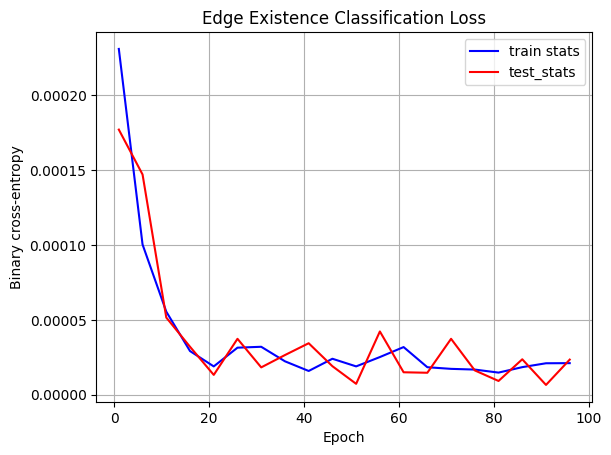

In [25]:
plot(train_stats['edge_bce'], test_stats['edge_bce'], "Binary cross-entropy", "Edge Existence Classification Loss", n_epochs, 'edge_bce')

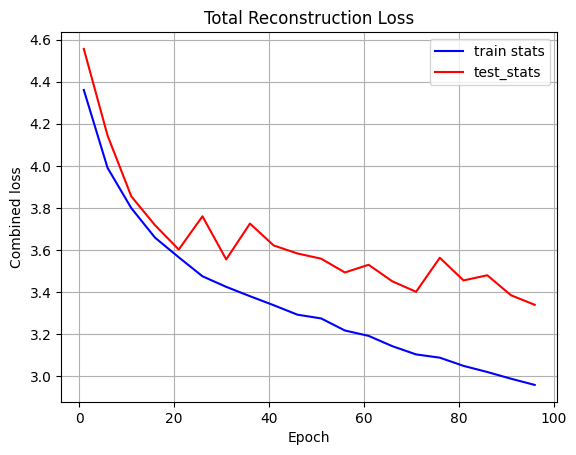

In [26]:
plot(train_stats['total'], test_stats['total'], "Combined loss", "Total Reconstruction Loss", n_epochs, 'total')

In [8]:
model = GAE()
model.load_state_dict(torch.load("gae.pt"))

<All keys matched successfully>

In [14]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=32,
                          shuffle=False)
model.compress(train_loader, "compressed_train")

In [15]:
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=32,
                         shuffle=False)
model.compress(test_loader, "compressed_test")

In [16]:
train_latent = torch.load("compressed_train.pt")

In [17]:
test_latent = torch.load("compressed_test.pt")